In [1]:
import matplotlib.pyplot as plt
from typing import List
from typing import Tuple
import numpy as np
import pandas
from sklearn import model_selection
from sklearn import neighbors
from sklearn import pipeline
from sklearn import preprocessing

In [2]:
SALES_PATH = "data/kc_house_data.csv"  # path to CSV with home sale data
DEMOGRAPHICS_PATH = "data/kc_house_data.csv"  # path to CSV with demographics
# List of columns (subset) that will be taken from home sale data
SALES_COLUMN_SELECTION = [
    'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
    'sqft_above', 'sqft_basement', 'zipcode'
]
OUTPUT_DIR = "model"  # Directory where output artifacts will be saved

In [3]:
def load_data(
    sales_path: str, demographics_path: str, sales_column_selection: List[str]
) -> Tuple[pandas.DataFrame, pandas.Series]:
    """Load the target and feature data by merging sales and demographics.

    Args:
        sales_path: path to CSV file with home sale data
        demographics_path: path to CSV file with home sale data
        sales_column_selection: list of columns from sales data to be used as
            features

    Returns:
        Tuple containg with two elements: a DataFrame and a Series of the same
        length.  The DataFrame contains features for machine learning, the
        series contains the target variable (home sale price).

    """
    data = pandas.read_csv(sales_path,
                           usecols=sales_column_selection,
                           dtype={'zipcode': str})
    demographics = pandas.read_csv("data/zipcode_demographics.csv",
                                   dtype={'zipcode': str})

    merged_data = data.merge(demographics, how="left",
                             on="zipcode").drop(columns="zipcode")
    # Remove the target variable from the dataframe, features will remain
    y = merged_data.pop('price')
    x = merged_data

    return x, y

In [4]:
x, y = load_data(SALES_PATH, DEMOGRAPHICS_PATH, SALES_COLUMN_SELECTION)
x_train, _x_test, y_train, _y_test = model_selection.train_test_split(
        x, y, random_state=42)

model = pipeline.make_pipeline(preprocessing.RobustScaler(),
                                   neighbors.KNeighborsRegressor()).fit(
                                       x_train, y_train)




In [5]:
y_pred = model.predict(_x_test)

In [6]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(_y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(_y_test, y_pred)
r2 = r2_score(_y_test, y_pred)

print(f" - MSE: {mse:.2f}")
print(f" - RMSE: {rmse:.2f}")
print(f" - MAE: {mae:.2f}")
print(f" - R²: {r2:.4f}")

 - MSE: 40666526377.04
 - RMSE: 201659.43
 - MAE: 102044.70
 - R²: 0.7281


In [7]:
from sklearn.model_selection import cross_val_score, KFold

n_folds = 5  # Número de folds para la validación cruzada
cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)

model_pipeline = pipeline.make_pipeline(
    preprocessing.RobustScaler(),
    neighbors.KNeighborsRegressor()
)

# Metrics with cross-validation
cv_scores_r2 = cross_val_score(model_pipeline, x, y, cv=cv, scoring='r2')
cv_scores_mae = cross_val_score(model_pipeline, x, y, cv=cv, scoring='neg_mean_absolute_error')
cv_scores_rmse = cross_val_score(model_pipeline, x, y, cv=cv, scoring='neg_root_mean_squared_error')

# Results
print(f"Cross-Validation results ({n_folds} folds):")
print(f"R² Score: {cv_scores_r2.mean():.4f} ± {cv_scores_r2.std():.4f}")
print(f"MAE: {-cv_scores_mae.mean():.4f} ± {cv_scores_mae.std():.4f}")
print(f"RMSE: {-cv_scores_rmse.mean():.4f} ± {cv_scores_rmse.std():.4f}")

Cross-Validation results (5 folds):
R² Score: 0.7488 ± 0.0118
MAE: 96290.7854 ± 2841.7079
RMSE: 183918.1646 ± 12862.8079


The model R² is near to 0.75 in test and in cross validation, as the difference is not so big it show the generalization could be good

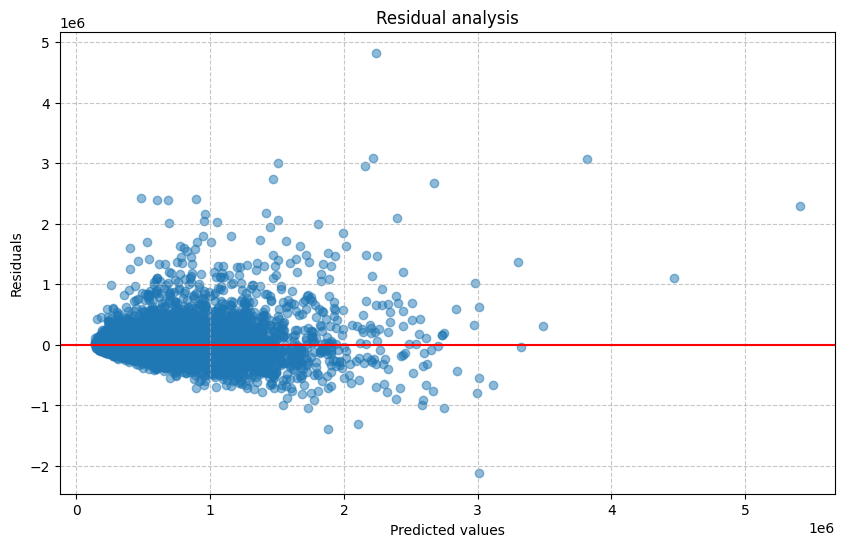

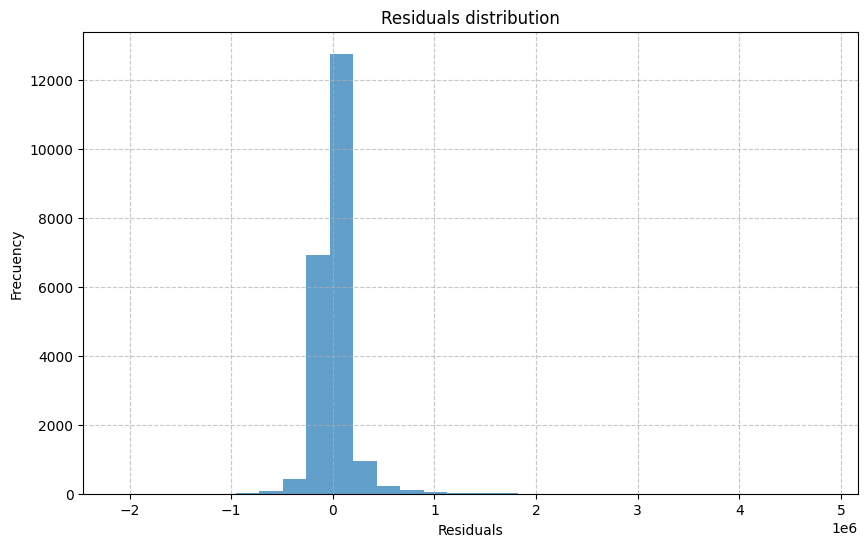

In [8]:
from sklearn.model_selection import cross_val_predict

# Predictions using cross-validation
y_pred = cross_val_predict(model, x, y, cv=5)

# Residual analysis
residuals = y - y_pred

# Residuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual analysis')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Residuals histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frecuency')
plt.title('Residuals distribution')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Residual analysis:
- The model predicts quite well on average.

- There's evidence of heteroscedasticity: residuals get larger as predicted values increase.

- Residuals are not perfectly normally distributed, but are mostly concentrated around zero, which is good.

- Outliers are present and should probably be investigated or handled.